# 2 Image Stitching

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def print_images(list_of_images):
    fig, ax = plt.subplots(1, len(list_of_images), figsize=(20,20))
    for i, (img,name) in enumerate(list_of_images):
        ax[i].set_title(str(name))
        ax[i].imshow(img);

In [3]:
path_to_data = "dataset/"

## 3.1 Coding question

### Training 1

In [4]:
folder = os.listdir(path_to_data)
data = {"train_volks": [],"train_ford": [],"test_volks": [], "test_ford": []}


for file_name in folder:
    img = cv2.cvtColor(cv2.imread(path_to_data + file_name), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    if "train" in file_name:
        if "ford" in file_name:
            data["train_ford"].append([img])
        else:
            data["train_volks"].append([img])
    else:
        if "ford" in file_name:
            data["test_ford"].append([img])
        else:
            data["test_volks"].append([img])

### Training 2

In [5]:
def compute_hog(list_of_img, cell_size, block_size, nbins):
    list_of_gradients = []
    for img in list_of_img:
        img = img[0]
        h, w, c = img.shape
        cell_h, cell_w = cell_size
        block_h, block_w = block_size
        
        hog = cv2.HOGDescriptor(_winSize=(w // cell_w * cell_w, h // cell_h * cell_h),
                                _blockSize=(block_w * block_w, block_h * block_h),
                                _blockStride=(cell_w, cell_h),
                                _cellSize=(cell_w, cell_h),
                                _nbins=nbins)
        n_cells = (h // cell_h, w // cell_w)

        # get the features
        hog_feats = hog.compute(img) \
                       .reshape(n_cells[1] - block_w + 1,
                                n_cells[0] - block_h + 1,
                                block_h, block_w, nbins) \
                       .transpose((1, 0, 2, 3, 4))  
                
        # computations for BlockNorm
        gradients = np.full((n_cells[0], n_cells[1], nbins), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_h):
            for off_x in range(block_w):
                gradients[off_y:n_cells[0] - block_h + off_y + 1, 
                          off_x:n_cells[1] - block_w + off_x + 1] += hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_h + off_y + 1,
                           off_x:n_cells[1] - block_w + off_x + 1] += 1
                
        # Average gradients and add it to the list to return
        gradients /= cell_count
        list_of_gradients.append(gradients)
        
    return list_of_gradients


In [6]:
cell_size = (4, 4)
block_size = (4, 4)
nbins = 8

hog_train_ford = compute_hog(data["train_ford"], cell_size, block_size, nbins)
hog_train_volks = compute_hog(data["train_volks"], cell_size, block_size, nbins)

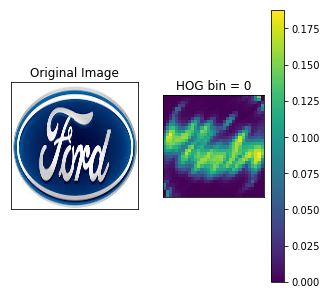

In [7]:
def display_hog(print_test_true, print_test_hog):
    plt.figure(figsize = (5,5))
    plt.subplot(121)
    plt.imshow(print_test_true, cmap='gray')
    plt.title("Original Image"), plt.xticks([]), plt.yticks([])

    plt.subplot(122)
    plt.pcolor(print_test_hog[:, :, 0])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("HOG bin = 0"), plt.xticks([]), plt.yticks([])
    plt.colorbar()
    plt.show()
    
    
display_hog(data["train_ford"][0][0], hog_train_ford[0])

### Training 3

In [8]:
# prep data
x_tr = np.array(hog_train_volks + hog_train_ford)
x_tr = x_tr.reshape(x_tr.shape[0], -1)
y_tr = [-1 for _ in range(len(hog_train_volks))] + [1 for _ in range(len(hog_train_ford))]

In [9]:
# get classifier
model = KNeighborsClassifier(n_neighbors=3)
model.fit(x_tr, y_tr)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

### Testing 1

See question Training 1. I saved all the images in a dictionary after resizing them.

### Testing 2

In [10]:
cell_size = (4, 4)
block_size = (4, 4)
nbins = 8

hog_test_ford = compute_hog(data["test_ford"], cell_size, block_size, nbins)
hog_test_volks = compute_hog(data["test_volks"], cell_size, block_size, nbins)

### Testing 3

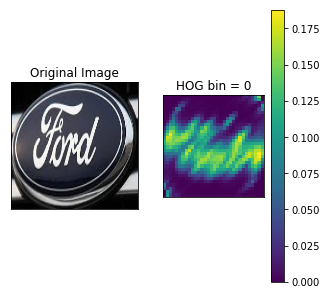

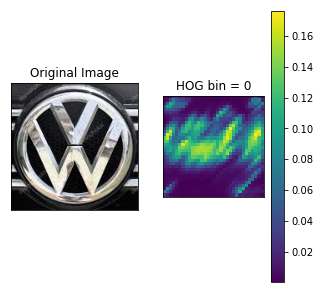

In [11]:
display_hog(data["test_ford"][0][0], hog_train_ford[0])
display_hog(data["test_volks"][0][0], hog_test_ford[0])

### Testing 4

[-1, 1]


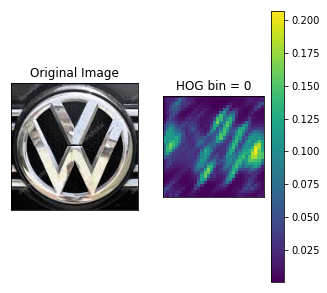

The above image was classified as -1.


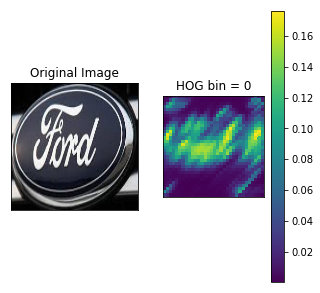

The above image was classified as 1.


In [12]:
x_test = np.array(hog_test_volks + hog_test_ford)
x_test = x_test.reshape(x_test.shape[0], -1)
y_test = [-1 for _ in range(len(hog_test_volks))] + [1 for _ in range(len(hog_test_ford))]

predictions = model.predict(x_test)
print(y_test)



display_hog(data["test_volks"][0][0], hog_test_volks[0])
print("The above image was classified as %s." % predictions[0])

display_hog(data["test_ford"][0][0], hog_test_ford[0])
print("The above image was classified as %s." % predictions[1])

## 3.2 Reasoning Questions

### 3.2.1
**Will HoG work if images of logos undergo random rotation? If yes, which property of HoG avails this feature? If not, discuss the sequence of computer vision technique(s) that can be used in order to regain uniform orientation of the logos. (3 points)**

No. HoG does not if images of logos undergo random rotation. In order to regain uniform oriantation, one would need to use what we did in the previous part of the assignment, meaning finding matching pairs and re-orient it so it matches.

### 3.2.2
**Consider that you are given a large dataset with three types of images: variable sized squares with either or both diagonals drawn (see Figure 3). How many and which directions of the gradient are sufficient in order to correctly classify the images into three categories? (2 points)**

2 directions are required. It would be pointing the 4 extremes but since there are negative and positive gradients, we can classify the 3 categories with only 2 directions of gradients.